In [42]:
import os
from io import BytesIO
import pandas as pd
import numpy as np
import msoffcrypto
import datetime


encrypted_path = "Cataracts_RTT_Patient_level_data_24-25.xlsx"
password = "PTL_cataracts_bristol2025"
possible_sheet_names = [
    "RTT_Patient_Level_data_24-25", "Patient Level", "Patient_Level", "Sheet1"
]

assert os.path.exists(encrypted_path), f"File not found: {encrypted_path}"
with open(encrypted_path, "rb") as f:
    office = msoffcrypto.OfficeFile(f)
    office.load_key(password=password)
    decrypted = BytesIO()
    office.decrypt(decrypted)


xls = pd.ExcelFile(decrypted)
sheet = next(s for s in possible_sheet_names if s in xls.sheet_names)
df = xls.parse(sheet)

print(f"Sheet: {sheet} | Shape: {df.shape}")


print("\nColumns:", list(df.columns))
missing = df.isna().sum()
missing = missing[missing > 0]
if not missing.empty:
    print("\nMissing by column (>0):")
    print((missing.to_frame("count")
                 .assign(pct=lambda x: 100*x["count"]/len(df))
                 .round(1)))


date_like = [c for c in df.columns
             if any(k in c.lower() for k in ["date", "clock", "start", "end", "activity"])]

for c in date_like:
    df[c] = pd.to_datetime(df[c], errors="coerce", dayfirst=True)


start_col = next((c for c in df.columns if any(k in c.lower() for k in ["start","clock"])), None)
end_col   = next((c for c in df.columns if any(k in c.lower() for k in ["end","activity"])), None)
print(f"\nStart column: {start_col} | End column: {end_col}")


if start_col and end_col:
    mask = df[start_col].notna() & df[end_col].notna()
    complete = df.loc[mask].copy()
    complete["waiting_time_days"] = (complete[end_col] - complete[start_col]).dt.days
    valid = complete.query("0 <= waiting_time_days <= 1000")

    print(f"\nComplete pathways: {len(complete)} ({len(complete)/len(df)*100:.1f}%)")
    if not valid.empty:
        wt = valid["waiting_time_days"]
        print("\nWaiting time stats (days):")
        print(f"min={wt.min()}  max={wt.max()}  mean={wt.mean():.1f}  "
              f"median={wt.median():.1f}  p95={wt.quantile(0.95):.1f}")
        print(f"18-week compliance (<=126d): {(wt.le(126).mean()*100):.1f}%")
        print("\nDistribution counts:")
        print(f"0–126: {wt.le(126).sum()}  "
              f"127–365: {wt.between(127,365).sum()}  "
              f">365: {wt.gt(365).sum()}")


provider_col = next((c for c in df.columns if "provider" in c.lower()), None)
if provider_col:
    pc = df[provider_col].value_counts()
    print(f"\nRecords per provider ({provider_col}):")
    print(pc)


hrg_col = next((c for c in df.columns if "hrg" in c.lower() and "description" not in c.lower()), None)
if hrg_col:
    hc = df[hrg_col].value_counts()
    print(f"\nRecords per HRG ({hrg_col}):")
    print(hc)

print("\nDtypes:")
print(df.dtypes)


Sheet: RTT_Patient_Level_data_24-25 | Shape: (8674, 12)

Columns: ['HRG', 'Activity Type', 'Provider', 'Local Patient Identifier', 'LSOA', 'HRG Description', 'Fin Year', 'Fin Month', 'Start_clock_date', 'End_clock_date', 'Priority', 'Independent Sector']

Missing by column (>0):
      count   pct
LSOA   1830  21.1

Start column: Start_clock_date | End column: Activity Type

Complete pathways: 0 (0.0%)

Records per provider (Provider):
Provider
NORTH WEST ANGLIA NHS FOUNDATION TRUST                            2220
CAMBRIDGE UNIVERSITY HOSPITALS NHS FOUNDATION TRUST               2014
ANGLIA COMMUNITY EYE SERVICE LTD                                  1793
SPAMEDICA PETERBOROUGH                                            1777
SPAMEDICA BEDFORD                                                  468
FITZWILLIAM HOSPITAL                                               152
COMMUNITY HEALTH AND EYECARE LIMITED                                42
NEWMEDICA SUFFOLK - BURY ST EDMUNDS - CLARITY HOUSE    

In [20]:
ref_start = df["Start_clock_date"].min()
ref_end   = df["Start_clock_date"].max()

print("Referral window in dataset:")
print(f"{ref_start} → {ref_end}")


Referral window in dataset:
2009-08-26 00:00:00 → 2025-03-28 00:00:00


In [21]:
analysis_start = "2023-04-01"
analysis_end   = "2025-03-31"

mask = (df["Start_clock_date"] >= analysis_start) & (df["Start_clock_date"] <= analysis_end)
df_window = df.loc[mask].copy()

print("Filtered referral window:")
print(df_window["Start_clock_date"].min(), "→", df_window["Start_clock_date"].max())


Filtered referral window:
2023-04-05 00:00:00 → 2025-03-28 00:00:00


In [24]:
import os
import msoffcrypto
import pandas as pd
from io import BytesIO

encrypted_path = "Cataracts_2325_patient_level.xlsb"

# === Step 2: Confirm file exists ===
if not os.path.exists(encrypted_path):
    raise FileNotFoundError(f"File not found at: {encrypted_path}")
else:
    print("Encrypted file found.")

with open(encrypted_path, "rb") as f:
    office_file = msoffcrypto.OfficeFile(f)
    office_file.load_key(password="PTL_cataracts_bristol2025")
    decrypted = BytesIO()
    office_file.decrypt(decrypted)
    print("File decrypted successfully.")


xls = pd.ExcelFile(decrypted, engine="pyxlsb")
print("Sheets found:", xls.sheet_names)

df2 = xls.parse("Patient Level")
print("Preview of 'Patient Level' sheet:")
display(df2.head())


Encrypted file found.
File decrypted successfully.
Sheets found: ['Pivot', 'Patient Level', 'Tariffs', 'SQL']
Preview of 'Patient Level' sheet:


,Activity Type,Provider,Local Patient Identifier,LSOA,HRG,HRG Description,Fin Year,Fin Month,Activity Date,Independent Sector
0,Inpatient/Day Case,CAMBRIDGE UNIVERSITY HOSPITALS NHS FOUNDATION ...,270506,E01018242,BZ31B,"Very Major, Cataract or Lens Procedures, with ...",2022/23,6,44816,No
1,Inpatient/Day Case,CAMBRIDGE UNIVERSITY HOSPITALS NHS FOUNDATION ...,1319077,E01018159,BZ31B,"Very Major, Cataract or Lens Procedures, with ...",2022/23,9,44914,No
2,Inpatient/Day Case,NORTH WEST ANGLIA NHS FOUNDATION TRUST,DIS3078757,E01018192,BZ31B,"Very Major, Cataract or Lens Procedures, with ...",2022/23,12,45013,No
3,Inpatient/Day Case,NORTH WEST ANGLIA NHS FOUNDATION TRUST,DIS3027712,E01015599,BZ31B,"Very Major, Cataract or Lens Procedures, with ...",2022/23,11,44978,No
4,Inpatient/Day Case,CAMBRIDGE UNIVERSITY HOSPITALS NHS FOUNDATION ...,930216,E01018051,BZ31B,"Very Major, Cataract or Lens Procedures, with ...",2022/23,9,44901,No


In [25]:
# Convert Excel serial dates to proper datetime
df2['Activity Date'] = pd.to_datetime(df2['Activity Date'], origin='1899-12-30', unit='D')

# Check the conversion worked
print(f"Date range: {df2['Activity Date'].min()} → {df2['Activity Date'].max()}")
print(f"Total surgeries: {len(df2)}")

# Now run the surgery analysis
surgery_analysis = {
    'daily_surgery_counts': df2.groupby('Activity Date').size(),
    'weekday_surgery_pattern': df2.groupby(df2['Activity Date'].dt.weekday).size(),
    'monthly_surgery_pattern': df2.groupby(df2['Activity Date'].dt.month).size(),
    'provider_capacity': df2.groupby('Provider').size(),
    'hrg_surgery_mix': df2.groupby('HRG').size()
}

print("\nSurgery patterns:")
print("Weekday pattern (0=Mon, 6=Sun):")
print(surgery_analysis['weekday_surgery_pattern'])

print("\nMonthly pattern:")
print(surgery_analysis['monthly_surgery_pattern'])

print(f"\nDaily surgery average: {len(df2) / len(surgery_analysis['daily_surgery_counts']):.1f} surgeries/day")

# Check date overlap with your referral data
print(f"\nReferral data: 2023-04-05 → 2025-03-28")
print(f"Surgery data: {df2['Activity Date'].min()} → {df2['Activity Date'].max()}")

Date range: 2022-04-01 00:00:00 → 2025-03-31 00:00:00
Total surgeries: 38547

Surgery patterns:
Weekday pattern (0=Mon, 6=Sun):
Activity Date
0    6265
1    8252
2    7704
3    7446
4    6535
5    1983
6     362
dtype: int64

Monthly pattern:
Activity Date
1     3709
2     3110
3     3893
4     2793
5     3471
6     3083
7     2945
8     3151
9     3194
10    3318
11    3345
12    2535
dtype: int64

Daily surgery average: 40.7 surgeries/day

Referral data: 2023-04-05 → 2025-03-28
Surgery data: 2022-04-01 00:00:00 → 2025-03-31 00:00:00


In [26]:
# Compare date ranges and overlaps
print("=== DATASET COVERAGE COMPARISON ===")
print(f"Referral data (df): {df['Start_clock_date'].min()} → {df['Start_clock_date'].max()}")
print(f"Surgery data (df2): {df2['Activity Date'].min()} → {df2['Activity Date'].max()}")

# Check overlap period
referral_start = pd.to_datetime(df['Start_clock_date'].min())
referral_end = pd.to_datetime(df['Start_clock_date'].max())
surgery_start = df2['Activity Date'].min()
surgery_end = df2['Activity Date'].max()

overlap_start = max(referral_start, surgery_start)
overlap_end = min(referral_end, surgery_end)

print(f"\nOverlap period: {overlap_start} → {overlap_end}")

# Filter surgery data to match referral period
surgery_in_overlap = df2[(df2['Activity Date'] >= overlap_start) & 
                        (df2['Activity Date'] <= overlap_end)]

print(f"\nSurgeries in overlap period: {len(surgery_in_overlap):,} (vs {len(df2):,} total)")
print(f"Referrals in overlap period: {len(df):,}")

# Recalculate conversion rate for overlap period only
matched_overlap = pd.merge(df, surgery_in_overlap, on='Local Patient Identifier', how='inner')
unique_referrals = df['Local Patient Identifier'].nunique()
unique_matched_overlap = matched_overlap['Local Patient Identifier'].nunique()

print(f"\n=== CORRECTED CONVERSION ANALYSIS ===")
print(f"Conversion rate (overlap period): {unique_matched_overlap/unique_referrals*100:.1f}%")
print(f"Matched patients in overlap: {len(matched_overlap):,}")

=== DATASET COVERAGE COMPARISON ===
Referral data (df): 2009-08-26 00:00:00 → 2025-03-28 00:00:00
Surgery data (df2): 2022-04-01 00:00:00 → 2025-03-31 00:00:00

Overlap period: 2022-04-01 00:00:00 → 2025-03-28 00:00:00

Surgeries in overlap period: 38,497 (vs 38,547 total)
Referrals in overlap period: 8,674

=== CORRECTED CONVERSION ANALYSIS ===
Conversion rate (overlap period): 99.2%
Matched patients in overlap: 13,766


In [33]:
simulation_start = '2023-04-01'
simulation_end = '2025-03-28'


# Filter referrals to simulation period
df_sim = df[(pd.to_datetime(df['Start_clock_date']) >= simulation_start) & 
            (pd.to_datetime(df['Start_clock_date']) <= simulation_end)]

# Filter surgeries to simulation period  
df2_sim = df2[(df2['Activity Date'] >= simulation_start) & 
              (df2['Activity Date'] <= simulation_end)]

print(f"Simulation period: {simulation_start} → {simulation_end}")
print(f"Referrals in period: {len(df_sim):,}")
print(f"Surgeries in period: {len(df2_sim):,}")

# Match for simulation period
matched_sim = pd.merge(df_sim, df2_sim, on='Local Patient Identifier', how='inner')

print(f"Matched patients: {len(matched_sim):,}")
print(f"Unique referred patients: {df_sim['Local Patient Identifier'].nunique():,}")
print(f"Unique surgery patients: {df2_sim['Local Patient Identifier'].nunique():,}")
print(f"Conversion rate: {matched_sim['Local Patient Identifier'].nunique()/df_sim['Local Patient Identifier'].nunique()*100:.1f}%")

# key parameters for this period
daily_referrals = len(df_sim) / ((pd.to_datetime(simulation_end) - pd.to_datetime(simulation_start)).days)
daily_surgeries = len(df2_sim) / len(df2_sim.groupby('Activity Date'))

print(f"\n=== KEY DES PARAMETERS (Apr 2023 - Mar 2025) ===")
print(f"Daily referrals: {daily_referrals:.1f}")
print(f"Daily surgeries: {daily_surgeries:.1f}")

print(matched_sim.head())

=== DES SIMULATION PERIOD ANALYSIS ===
Simulation period: 2023-04-01 → 2025-03-28
Referrals in period: 8,519
Surgeries in period: 26,904
Matched patients: 13,199
Unique referred patients: 6,882
Unique surgery patients: 17,483
Conversion rate: 99.2%

=== KEY DES PARAMETERS (Apr 2023 - Mar 2025) ===
Daily referrals: 11.7
Daily surgeries: 42.2
   HRG_x Activity Type_x                        Provider_x  \
0  BZ31A             NaT  ANGLIA COMMUNITY EYE SERVICE LTD   
1  BZ31A             NaT  ANGLIA COMMUNITY EYE SERVICE LTD   
2  BZ31A             NaT  ANGLIA COMMUNITY EYE SERVICE LTD   
3  BZ31A             NaT  ANGLIA COMMUNITY EYE SERVICE LTD   
4  BZ31A             NaT  ANGLIA COMMUNITY EYE SERVICE LTD   

  Local Patient Identifier LSOA_x  \
0                 62721612    NaN   
1                 62721612    NaN   
2                 51568750    NaN   
3                 51568750    NaN   
4                 63030672    NaN   

                                   HRG Description_x Fin Year

### Arrival Rate

Daily arrivals data created: 622 days
Date range: 2023-04-05 00:00:00 to 2025-03-28 00:00:00
Average daily arrivals: 13.7
Weekdays: n=508, μ=15.96, σ=11.00
Weekends: n=114, μ=3.59, σ=3.07
WEEKDAY ARRIVALS:
Weekday - Negative Binomial: r=2.43, p=0.132, KS_D=0.0805, p=0.002597
Weekday - Gamma: shape=1.67, scale=9.58, KS_D=0.0822, p=0.001960
Weekday - Lognormal: σ=0.91, scale=11.65, KS_D=0.1281, p=0.000000

WEEKEND ARRIVALS:
Weekend - Negative Binomial: r=2.21, p=0.382, KS_D=0.2807, p=0.000000
Weekend - Gamma: shape=1.58, scale=2.27, KS_D=0.2017, p=0.000152
Weekend - Lognormal: σ=0.80, scale=2.67, KS_D=0.2165, p=0.000036


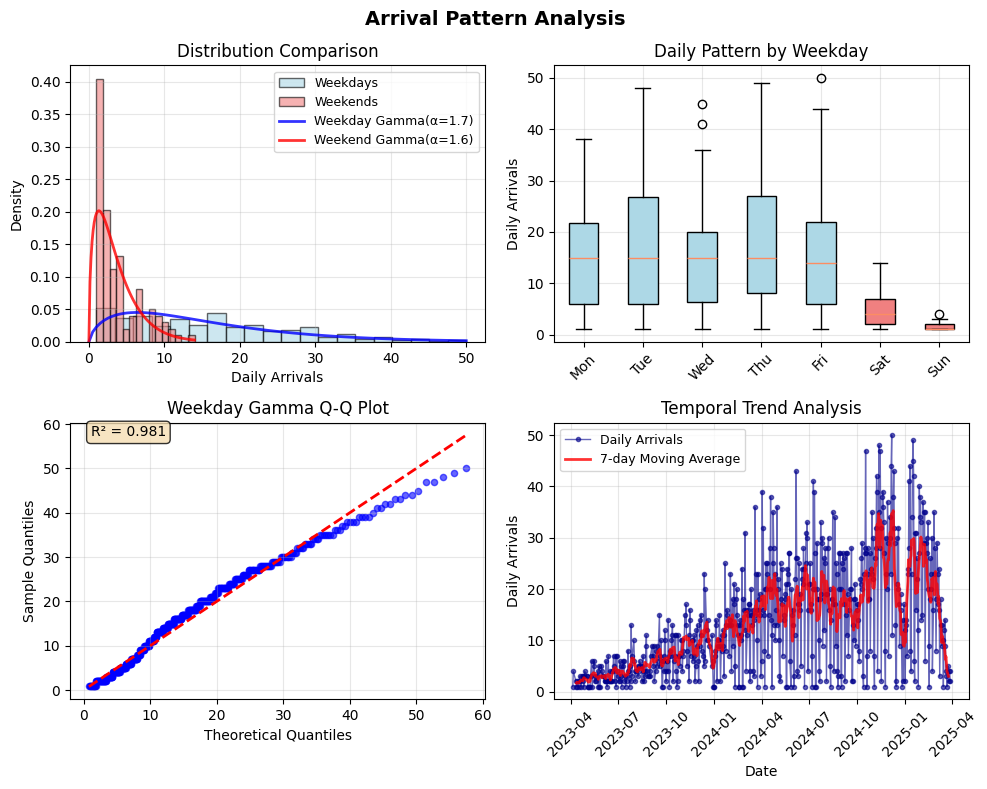

Weekday arrivals (Mon-Fri):
  - Gamma distribution: α=1.67, β=9.58
  - Negative Binomial: r=2.43, p=0.132
  - Average rate: 16.0 arrivals/day

Weekend arrivals (Sat-Sun):
  - Gamma distribution: α=1.58, β=2.27
  - Negative Binomial: r=2.21, p=0.382
  - Average rate: 3.6 arrivals/day

Day-specific rates for fine-grained modeling:
  Mon: μ=14.8, σ=9.4, CV=0.64
  Tue: μ=17.3, σ=12.1, CV=0.70
  Wed: μ=14.8, σ=9.9, CV=0.67
  Thu: μ=17.8, σ=12.1, CV=0.68
  Fri: μ=15.1, σ=10.8, CV=0.71
  Sat: μ=4.5, σ=3.3, CV=0.72
  Sun: μ=1.6, σ=0.8, CV=0.53

 model validation metrics
Distribution fit quality (p-values):
Weekday Gamma: p=0.001960
Weekend Gamma: p=0.000152
Weekday NegBinom: p=0.002597
Weekend NegBinom: p=0.000000
Weekend reduction factor: 22.5%
Lag-1 correlation: 0.530 (significant autocorrelation)


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')


df_sim['Start_clock_date'] = pd.to_datetime(df_sim['Start_clock_date'])

# Create daily arrivals count
daily_arrivals = df_sim.groupby(df_sim['Start_clock_date'].dt.date).size().reset_index()
daily_arrivals.columns = ['date', 'arrivals']
daily_arrivals['date'] = pd.to_datetime(daily_arrivals['date'])

# Add temporal features
daily_arrivals['day_of_week'] = daily_arrivals['date'].dt.day_name()
daily_arrivals['day_of_week_num'] = daily_arrivals['date'].dt.dayofweek
daily_arrivals['month'] = daily_arrivals['date'].dt.month
daily_arrivals['is_weekend'] = daily_arrivals['day_of_week_num'].isin([5, 6])  # Sat=5, Sun=6
daily_arrivals['ma'] = daily_arrivals['arrivals'].rolling(window=7, center=True).mean()

print(f"Daily arrivals data created: {len(daily_arrivals)} days")
print(f"Date range: {daily_arrivals['date'].min()} to {daily_arrivals['date'].max()}")
print(f"Average daily arrivals: {daily_arrivals['arrivals'].mean():.1f}")

# weekday vs weekend 
weekday_arrivals = daily_arrivals[~daily_arrivals['is_weekend']]['arrivals'].values
weekend_arrivals = daily_arrivals[daily_arrivals['is_weekend']]['arrivals'].values

print(f"Weekdays: n={len(weekday_arrivals)}, μ={np.mean(weekday_arrivals):.2f}, σ={np.std(weekday_arrivals):.2f}")
print(f"Weekends: n={len(weekend_arrivals)}, μ={np.mean(weekend_arrivals):.2f}, σ={np.std(weekend_arrivals):.2f}")

# Test distributions separately for weekdays and weekends
def test_negative_binomial(data, name):
    """Fit negative binomial using method of moments"""
    mean_val = np.mean(data)
    var_val = np.var(data)
    
    if var_val <= mean_val:
        return None, None, None
    
    # Method of moments for negative binomial
    p = mean_val / var_val
    r = mean_val * p / (1 - p)
    
    # KS test
    ks_stat, ks_p = stats.kstest(data, lambda x: stats.nbinom.cdf(x, r, p))
    
    print(f"{name} - Negative Binomial: r={r:.2f}, p={p:.3f}, KS_D={ks_stat:.4f}, p={ks_p:.6f}")
    return r, p, ks_p

def test_gamma_discrete(data, name):
    """Fit Gamma distribution to discrete count data"""
    # Fit gamma to continuous approximation
    shape, loc, scale = stats.gamma.fit(data, floc=0)
    
    # For discrete data, we'll use the continuous CDF
    ks_stat, ks_p = stats.kstest(data, lambda x: stats.gamma.cdf(x, shape, loc=loc, scale=scale))
    
    print(f"{name} - Gamma: shape={shape:.2f}, scale={scale:.2f}, KS_D={ks_stat:.4f}, p={ks_p:.6f}")
    return shape, scale, ks_p

def test_lognormal_discrete(data, name):
    """Fit lognormal distribution"""
    # Add small constant to handle zeros
    data_adj = data + 0.1
    sigma, loc, scale = stats.lognorm.fit(data_adj, floc=0)
    
    ks_stat, ks_p = stats.kstest(data, lambda x: stats.lognorm.cdf(x + 0.1, sigma, loc=loc, scale=scale))
    
    print(f"{name} - Lognormal: σ={sigma:.2f}, scale={scale:.2f}, KS_D={ks_stat:.4f}, p={ks_p:.6f}")
    return sigma, scale, ks_p


# Weekday distributions
print("WEEKDAY ARRIVALS:")
wd_nb = test_negative_binomial(weekday_arrivals, "Weekday")
wd_gamma = test_gamma_discrete(weekday_arrivals, "Weekday") 
wd_lognorm = test_lognormal_discrete(weekday_arrivals, "Weekday")

# Weekend distributions  
print("\nWEEKEND ARRIVALS:")
we_nb = test_negative_binomial(weekend_arrivals, "Weekend")
we_gamma = test_gamma_discrete(weekend_arrivals, "Weekend")
we_lognorm = test_lognormal_discrete(weekend_arrivals, "Weekend")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Arrival Pattern Analysis', fontsize=14, fontweight='bold')


axes[0,0].hist(weekday_arrivals, bins=20, density=True, alpha=0.6, color='lightblue', 
               edgecolor='black', label='Weekdays')
axes[0,0].hist(weekend_arrivals, bins=15, density=True, alpha=0.6, color='lightcoral', 
               edgecolor='black', label='Weekends')

# Fit and overlay distributions
x_cont_wd = np.linspace(0, max(weekday_arrivals), 100)
gamma_pdf_wd = stats.gamma.pdf(x_cont_wd, wd_gamma[0], scale=wd_gamma[1])
axes[0,0].plot(x_cont_wd, gamma_pdf_wd, 'b-', linewidth=2, alpha=0.8, 
               label=f'Weekday Gamma(α={wd_gamma[0]:.1f})')

x_cont_we = np.linspace(0, max(weekend_arrivals), 100)
gamma_pdf_we = stats.gamma.pdf(x_cont_we, we_gamma[0], scale=we_gamma[1])
axes[0,0].plot(x_cont_we, gamma_pdf_we, 'r-', linewidth=2, alpha=0.8, 
               label=f'Weekend Gamma(α={we_gamma[0]:.1f})')

axes[0,0].set_title('Distribution Comparison', fontsize=12)
axes[0,0].set_xlabel('Daily Arrivals')
axes[0,0].set_ylabel('Density')
axes[0,0].legend(fontsize=9)

# Top Right: Day-of-week box plot
dow_data = []
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    day_arrivals = daily_arrivals[daily_arrivals['day_of_week_num']==i]['arrivals'].values
    if len(day_arrivals) > 10:
        dow_data.append({
            'day': dow_names[i],
            'day_num': i,
            'arrivals': day_arrivals,
            'mean': np.mean(day_arrivals),
            'std': np.std(day_arrivals),
            'cv': np.std(day_arrivals)/np.mean(day_arrivals) if np.mean(day_arrivals) > 0 else 0
        })

day_arrivals_list = [d['arrivals'] for d in dow_data]
day_labels = [d['day'] for d in dow_data]
bp = axes[0,1].boxplot(day_arrivals_list, labels=day_labels, patch_artist=True)

# Color weekdays and weekends differently
colors = ['lightblue'] * 5 + ['lightcoral'] * 2
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

axes[0,1].set_title('Daily Pattern by Weekday', fontsize=12)
axes[0,1].set_ylabel('Daily Arrivals')
axes[0,1].tick_params(axis='x', rotation=45)

# Bottom Left: Q-Q Plot for best fit (Weekday Gamma)
sorted_wd = np.sort(weekday_arrivals)
theoretical_quantiles_wd = stats.gamma.ppf(np.linspace(0.01, 0.99, len(sorted_wd)), 
                                           wd_gamma[0], scale=wd_gamma[1])
axes[1,0].scatter(theoretical_quantiles_wd, sorted_wd, alpha=0.6, color='blue', s=20)
axes[1,0].plot([min(theoretical_quantiles_wd), max(theoretical_quantiles_wd)], 
               [min(theoretical_quantiles_wd), max(theoretical_quantiles_wd)], 'r--', linewidth=2)
axes[1,0].set_title('Weekday Gamma Q-Q Plot', fontsize=12)
axes[1,0].set_xlabel('Theoretical Quantiles')
axes[1,0].set_ylabel('Sample Quantiles')

# Add R-squared
r_squared = np.corrcoef(theoretical_quantiles_wd, sorted_wd)[0,1]**2
axes[1,0].text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=axes[1,0].transAxes, 
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=10)

# Bottom Right: Time series with trend
axes[1,1].plot(daily_arrivals['date'], daily_arrivals['arrivals'], 'o-', 
               alpha=0.6, markersize=3, linewidth=1, color='darkblue', label='Daily Arrivals')
axes[1,1].plot(daily_arrivals['date'], daily_arrivals['ma'], 'r-', 
               linewidth=2, alpha=0.8, label='7-day Moving Average')
axes[1,1].set_title('Temporal Trend Analysis', fontsize=12)
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Daily Arrivals')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend(fontsize=9)

# Add grid for better readability
for ax in axes.flat:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Specific parameters for implementation
print("Weekday arrivals (Mon-Fri):")
print(f"  - Gamma distribution: α={wd_gamma[0]:.2f}, β={wd_gamma[1]:.2f}")
if wd_nb[0] is not None:
    print(f"  - Negative Binomial: r={wd_nb[0]:.2f}, p={wd_nb[1]:.3f}")
print(f"  - Average rate: {np.mean(weekday_arrivals):.1f} arrivals/day")
print()

print("Weekend arrivals (Sat-Sun):")
print(f"  - Gamma distribution: α={we_gamma[0]:.2f}, β={we_gamma[1]:.2f}")
if we_nb[0] is not None:
    print(f"  - Negative Binomial: r={we_nb[0]:.2f}, p={we_nb[1]:.3f}")
print(f"  - Average rate: {np.mean(weekend_arrivals):.1f} arrivals/day")
print()

print("Day-specific rates for fine-grained modeling:")
for d in dow_data:
    print(f"  {d['day']}: μ={d['mean']:.1f}, σ={d['std']:.1f}, CV={d['cv']:.2f}")

# Lag analysis
lag1_corr = np.corrcoef(daily_arrivals['arrivals'][:-1], daily_arrivals['arrivals'][1:])[0,1]

print(f"\n model validation metrics")
print("Distribution fit quality (p-values):")
print(f"Weekday Gamma: p={wd_gamma[2]:.6f}")
print(f"Weekend Gamma: p={we_gamma[2]:.6f}")
if wd_nb[2] is not None:
    print(f"Weekday NegBinom: p={wd_nb[2]:.6f}")
if we_nb[2] is not None:
    print(f"Weekend NegBinom: p={we_nb[2]:.6f}")

# Store results for generator
enhanced_arrival_params = {
    'weekday_gamma': {'shape': wd_gamma[0], 'scale': wd_gamma[1], 'fit_p': wd_gamma[2]},
    'weekend_gamma': {'shape': we_gamma[0], 'scale': we_gamma[1], 'fit_p': we_gamma[2]},
    'weekday_negbinom': {'r': wd_nb[0], 'p': wd_nb[1], 'fit_p': wd_nb[2]} if wd_nb[0] else None,
    'weekend_negbinom': {'r': we_nb[0], 'p': we_nb[1], 'fit_p': we_nb[2]} if we_nb[0] else None,
    'day_specific_params': {d['day']: {'mean': d['mean'], 'std': d['std'], 'cv': d['cv']} for d in dow_data},
    'lag1_correlation': lag1_corr,
    'weekend_reduction_factor': np.mean(weekend_arrivals) / np.mean(weekday_arrivals)
}

print(f"Weekend reduction factor: {enhanced_arrival_params['weekend_reduction_factor']:.1%}")
print(f"Lag-1 correlation: {lag1_corr:.3f} ({'significant' if abs(lag1_corr) > 0.1 else 'negligible'} autocorrelation)")

### Service Capacity Parameters

Mean daily surgeries: 23.8
Max daily surgeries: 105
Active surgery days: 555


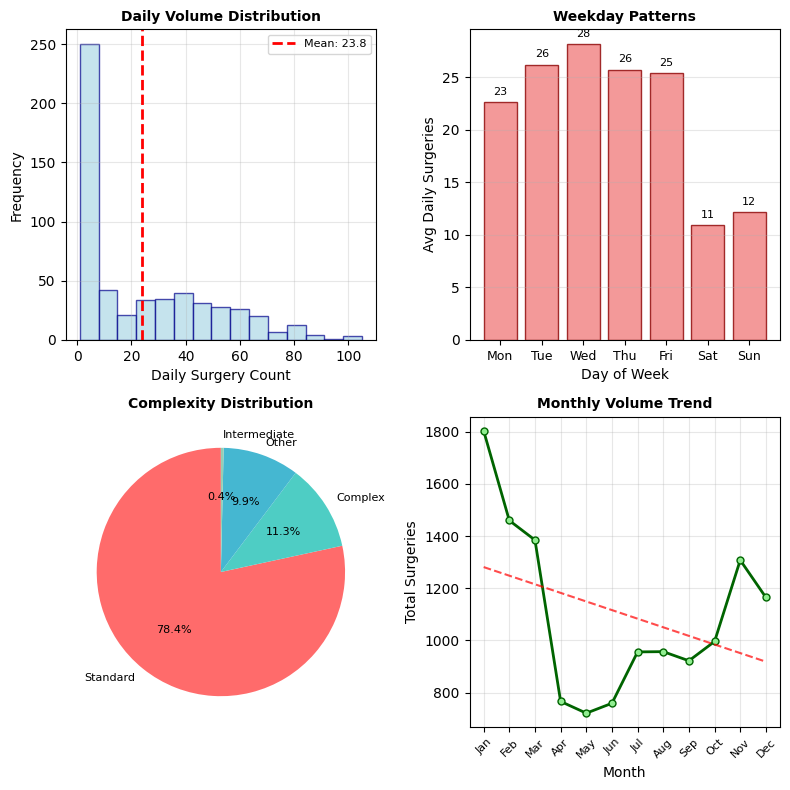

Total surgeries: 13,199
Study period: Apr 2023 - Mar 2025
Mean daily volume: 23.8 ± 24.7
Peak daily volume: 105
Active surgery days: 555 / 555 (100.0%)
Weekday average: 25.6 surgeries/day

Complexity breakdown:
  Standard: 78.4%
  Complex: 11.3%
  Other: 9.9%
  Intermediate: 0.4%


In [40]:
matched_sim['Activity Date'] = pd.to_datetime(matched_sim['Activity Date'])
matched_sim['weekday'] = matched_sim['Activity Date'].dt.day_name()
matched_sim['month'] = matched_sim['Activity Date'].dt.month


def map_hrg_to_complexity(hrg_code):
    if pd.isna(hrg_code):
        return 'Unknown'
    hrg_code = str(hrg_code).upper()
    if 'BZ34' in hrg_code:
        return 'Standard'
    elif 'BZ31' in hrg_code:
        return 'Complex'
    elif 'BZ32' in hrg_code:
        return 'Intermediate'
    else:
        return 'Other'

matched_sim['complexity_inferred'] = matched_sim['HRG_y'].apply(map_hrg_to_complexity)

# Daily surgery volumes
daily_surgeries = matched_sim.groupby('Activity Date').size().reset_index(name='daily_count')
daily_surgeries['weekday'] = daily_surgeries['Activity Date'].dt.day_name()


print(f"Mean daily surgeries: {daily_surgeries['daily_count'].mean():.1f}")
print(f"Max daily surgeries: {daily_surgeries['daily_count'].max()}")
print(f"Active surgery days: {len(daily_surgeries[daily_surgeries['daily_count'] > 0])}")


# visuals 

def create_compact_capacity_figure(matched_sim):
    
    daily_surgeries = matched_sim.groupby('Activity Date').size().reset_index(name='daily_count')
    daily_surgeries['weekday'] = daily_surgeries['Activity Date'].dt.day_name()
    
    
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    
    
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.88, bottom=0.1)
    
    # 1. Daily Surgery Volume Distribution
    ax = axes[0, 0]
    n, bins, patches = ax.hist(daily_surgeries['daily_count'], bins=15, alpha=0.7, 
                              color='lightblue', edgecolor='darkblue', linewidth=1)
    ax.axvline(daily_surgeries['daily_count'].mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Mean: {daily_surgeries["daily_count"].mean():.1f}')
    ax.set_xlabel('Daily Surgery Count', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title('Daily Volume Distribution', fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    
    # 2. Weekday Surgery Patterns
    ax = axes[0, 1]
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_stats = daily_surgeries.groupby('weekday')['daily_count'].mean().reindex(weekday_order).dropna()
    
    bars = ax.bar(range(len(weekday_stats)), weekday_stats.values, 
                  color='lightcoral', edgecolor='darkred', linewidth=1, alpha=0.8)
    
    ax.set_xticks(range(len(weekday_stats)))
    ax.set_xticklabels([day[:3] for day in weekday_stats.index], fontsize=9)
    ax.set_xlabel('Day of Week', fontsize=10)
    ax.set_ylabel('Avg Daily Surgeries', fontsize=10)
    ax.set_title('Weekday Patterns', fontsize=10, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars, weekday_stats.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
               f'{value:.0f}', ha='center', va='bottom', fontsize=8)
    
    # 3. Surgery Complexity Distribution
    ax = axes[1, 0]
    complexity_counts = matched_sim['complexity_inferred'].value_counts()
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(complexity_counts)]
    
    wedges, texts, autotexts = ax.pie(complexity_counts.values, labels=complexity_counts.index, 
                                     autopct='%1.1f%%', colors=colors, startangle=90,
                                     textprops={'fontsize': 8})
    ax.set_title('Complexity Distribution', fontsize=10, fontweight='bold')
    
    # 4. Monthly Surgery Volume Trend
    ax = axes[1, 1]
    monthly_counts = matched_sim.groupby('month').size()
    month_names = [datetime(2023, m, 1).strftime('%b') for m in monthly_counts.index]
    
    ax.plot(month_names, monthly_counts.values, marker='o', linewidth=2, 
            markersize=5, color='darkgreen', markerfacecolor='lightgreen')
    
    # Add trend line
    x_numeric = np.arange(len(monthly_counts))
    z = np.polyfit(x_numeric, monthly_counts.values, 1)
    p = np.poly1d(z)
    ax.plot(month_names, p(x_numeric), linestyle='--', color='red', alpha=0.7, linewidth=1.5)
    
    ax.set_xlabel('Month', fontsize=10)
    ax.set_ylabel('Total Surgeries', fontsize=10)
    ax.set_title('Monthly Volume Trend', fontsize=10, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.grid(alpha=0.3)
    
    # Make layout tight
    plt.tight_layout()
    
    return fig

fig = create_compact_capacity_figure(matched_sim)
plt.show()


print(f"Total surgeries: {len(matched_sim):,}")
print(f"Study period: {matched_sim['Activity Date'].min().strftime('%b %Y')} - {matched_sim['Activity Date'].max().strftime('%b %Y')}")
print(f"Mean daily volume: {daily_surgeries['daily_count'].mean():.1f} ± {daily_surgeries['daily_count'].std():.1f}")
print(f"Peak daily volume: {daily_surgeries['daily_count'].max()}")
print(f"Active surgery days: {len(daily_surgeries[daily_surgeries['daily_count'] > 0])} / {len(daily_surgeries)} ({len(daily_surgeries[daily_surgeries['daily_count'] > 0])/len(daily_surgeries)*100:.1f}%)")

# Weekday summary
weekday_summary = daily_surgeries.groupby('weekday')['daily_count'].mean()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekday_business = weekday_summary.reindex(weekday_order).dropna()
print(f"Weekday average: {weekday_business.mean():.1f} surgeries/day")

# Complexity breakdown
complexity_pct = matched_sim['complexity_inferred'].value_counts(normalize=True) * 100
print("\nComplexity breakdown:")
for complexity, pct in complexity_pct.items():
    print(f"  {complexity}: {pct:.1f}%")

### Patient Mix & Complexity

In [ ]:
plt.style.use('default')
sns.set_palette("husl")
fig = plt.figure(figsize=(20, 16))


# 1. HRG Complexity Distribution
print("1. HRG COMPLEXITY DISTRIBUTION")
hrg_dist = df2_sim['HRG'].value_counts()
hrg_percent = df2_sim['HRG'].value_counts(normalize=True) * 100

print("HRG distribution:")
for hrg, count in hrg_dist.items():
    print(f"  {hrg}: {count:,} surgeries ({hrg_percent[hrg]:.1f}%)")


hrg_desc = df2_sim.groupby('HRG')['HRG Description'].first()
print(f"\nHRG Descriptions:")
for hrg in hrg_dist.index:
    desc = hrg_desc[hrg][:50] + "..." if len(hrg_desc[hrg]) > 50 else hrg_desc[hrg]
    print(f"  {hrg}: {desc}")

# 2. Priority Distribution 
print(f"\n2. Priority distribution")
if 'Priority' in df_sim.columns:
    priority_dist = df_sim['Priority'].value_counts()
    priority_percent = df_sim['Priority'].value_counts(normalize=True) * 100
    print("Priority distribution:")
    for priority, count in priority_dist.items():
        print(f"  {priority}: {count:,} referrals ({priority_percent[priority]:.1f}%)")
else:
    print("Priority column not found")

# 3. Bilateral Surgery Analysis
print(f"\n3. Bilateral Surgery Analysis")
patient_surgery_counts = df2_sim['Local Patient Identifier'].value_counts()
bilateral_patients = patient_surgery_counts[patient_surgery_counts > 1]

print(f"Single surgery patients: {(patient_surgery_counts == 1).sum():,}")
print(f"Bilateral surgery patients: {len(bilateral_patients):,}")
print(f"Bilateral rate: {len(bilateral_patients)/len(patient_surgery_counts)*100:.1f}%")

# Inter-eye intervals for bilateral patients
bilateral_data = df2_sim[df2_sim['Local Patient Identifier'].isin(bilateral_patients.index)]
bilateral_intervals = bilateral_data.groupby('Local Patient Identifier')['Activity Date'].apply(
    lambda x: (x.max() - x.min()).days if len(x) == 2 else None
)
bilateral_intervals = bilateral_intervals.dropna()

print(f"Mean inter-eye interval: {bilateral_intervals.mean():.1f} days")
print(f"Median inter-eye interval: {bilateral_intervals.median():.1f} days")
print(f"Std dev inter-eye interval: {bilateral_intervals.std():.1f} days")

# ===== VISUALIZATIONS USING THE GENERATED DATA =====

# Color mapping for complexity levels
def get_complexity_color(hrg_code):
    complexity_colors = {
        'BZ33Z': '#2E8B57',  # Minor - Green
        'BZ34C': '#4682B4',  # Standard Phaco - Blue  
        'BZ34B': '#1E90FF',  # Phaco with complications - Light Blue
        'BZ34A': '#FF6347',  # Complex Phaco - Red
        'BZ31B': '#FF4500',  # Very Major - Orange Red
        'BZ31A': '#FF4500',  # Very Major with complications - Orange Red
        'BZ30B': '#8B0000',  # Complex - Dark Red
        'BZ30A': '#8B0000',  # Complex with complications - Dark Red
        'BZ32B': '#9932CC',  # Intermediate - Purple
        'BZ32A': '#9932CC'   # Intermediate - Purple
    }
    return complexity_colors.get(hrg_code, '#808080')

# 1. HRG Complexity Distribution
ax1 = plt.subplot(2, 3, 1)
hrg_codes = hrg_dist.index.tolist()
hrg_counts = hrg_dist.values
hrg_percentages = hrg_percent.values

colors = [get_complexity_color(code) for code in hrg_codes]
bars = ax1.barh(range(len(hrg_codes)), hrg_counts, color=colors)
ax1.set_yticks(range(len(hrg_codes)))
ax1.set_yticklabels(hrg_codes)
ax1.set_xlabel('Number of Surgeries')
ax1.set_title('HRG Distribution\n(Surgery Volume by Code)', fontweight='bold', pad=20)

# Add percentage labels
for i, (count, pct) in enumerate(zip(hrg_counts, hrg_percentages)):
    ax1.text(count + max(hrg_counts)*0.01, i, f'{pct:.1f}%', va='center', fontweight='bold')

# 2. HRG Complexity Pie Chart
ax2 = plt.subplot(2, 3, 2)
labels = [f'{code}\n({pct:.1f}%)' for code, pct in zip(hrg_codes, hrg_percentages)]

wedges, texts, autotexts = ax2.pie(hrg_percentages, labels=labels, colors=colors, 
                                   autopct='', startangle=90)
ax2.set_title('HRG Complexity Distribution\n(Percentage Breakdown)', fontweight='bold', pad=20)

# Make text smaller for readability
for text in texts:
    text.set_fontsize(8)

# 3. Priority Distribution
ax3 = plt.subplot(2, 3, 3)
if 'Priority' in df_sim.columns:
    priorities = priority_dist.index.tolist()
    priority_counts_vals = priority_dist.values
    priority_percentages = priority_percent.values
    
    priority_labels = [f'Priority {p}' for p in priorities]
    colors_priority = ['#2E8B57', '#FFD700', '#FF4500'][:len(priorities)]
    
    bars = ax3.bar(priority_labels, priority_counts_vals, color=colors_priority)
    ax3.set_ylabel('Number of Referrals')
    ax3.set_title('Referral Priority Distribution', fontweight='bold', pad=20)
    
    # Add percentage labels on bars
    for i, (count, pct) in enumerate(zip(priority_counts_vals, priority_percentages)):
        ax3.text(i, count + max(priority_counts_vals)*0.02, f'{pct:.1f}%', ha='center', fontweight='bold')
    
    ax3.set_ylim(0, max(priority_counts_vals) * 1.1)
else:
    ax3.text(0.5, 0.5, 'Priority data\nnot available', ha='center', va='center', 
             transform=ax3.transAxes, fontsize=14)
    ax3.set_title('Priority Distribution\n(Data Not Available)', fontweight='bold', pad=20)

# 4. Bilateral Surgery Analysis
ax4 = plt.subplot(2, 3, 4)
single_count = (patient_surgery_counts == 1).sum()
bilateral_count = len(bilateral_patients)
total_patients = single_count + bilateral_count

bilateral_labels = ['Single Eye\nSurgery', 'Bilateral\nSurgery']
bilateral_counts_vals = [single_count, bilateral_count]
bilateral_colors = ['#87CEEB', '#4169E1']

bars = ax4.bar(bilateral_labels, bilateral_counts_vals, color=bilateral_colors)
ax4.set_ylabel('Number of Patients')
ax4.set_title('Bilateral Surgery Patterns', fontweight='bold', pad=20)

# Add percentage labels
for i, count in enumerate(bilateral_counts_vals):
    pct = count/total_patients * 100
    ax4.text(i, count + max(bilateral_counts_vals)*0.02, f'{pct:.1f}%', ha='center', fontweight='bold')

ax4.set_ylim(0, max(bilateral_counts_vals) * 1.1)

# 5. Inter-eye Interval Distribution
ax5 = plt.subplot(2, 3, 5)
if len(bilateral_intervals) > 0:
    # Filter extreme outliers for better visualization
    intervals_filtered = bilateral_intervals[bilateral_intervals <= bilateral_intervals.quantile(0.95)]
    
    ax5.hist(intervals_filtered, bins=30, color='#20B2AA', alpha=0.7, edgecolor='black')
    ax5.axvline(bilateral_intervals.mean(), color='red', linestyle='--', 
               label=f'Mean: {bilateral_intervals.mean():.1f} days')
    ax5.axvline(bilateral_intervals.median(), color='orange', linestyle='--',
               label=f'Median: {bilateral_intervals.median():.1f} days')
    
    ax5.set_xlabel('Days Between First and Second Eye Surgery')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Inter-eye Interval Distribution\n(Bilateral Surgery Patients)', fontweight='bold', pad=20)
    ax5.legend()
else:
    ax5.text(0.5, 0.5, 'No bilateral\ninterval data', ha='center', va='center', 
             transform=ax5.transAxes, fontsize=14)
    ax5.set_title('Inter-eye Intervals\n(No Data Available)', fontweight='bold', pad=20)

# 6. Top HRG Procedures Summary
ax6 = plt.subplot(2, 3, 6)
# Take top 6 HRG codes for better visualization
top_hrgs = hrg_dist.head(6)
top_hrg_codes = top_hrgs.index.tolist()
top_hrg_percentages = hrg_percent[top_hrg_codes].values

# Simplified labels using HRG descriptions
simplified_labels = []
for code in top_hrg_codes:
    desc = hrg_desc[code]
    if 'Minor' in desc:
        simplified_labels.append('Minor\nProcedures')
    elif 'Phacoemulsification' in desc:
        if 'CC Score' in desc:
            simplified_labels.append('Phaco +\nComplications')
        else:
            simplified_labels.append('Standard\nPhaco')
    elif 'Very Major' in desc:
        simplified_labels.append('Very Major\nProcedures')
    elif 'Complex' in desc:
        simplified_labels.append('Complex\nProcedures')
    elif 'Intermediate' in desc:
        simplified_labels.append('Intermediate\nProcedures')
    else:
        simplified_labels.append(code)

colors_top = [get_complexity_color(code) for code in top_hrg_codes]
bars = ax6.bar(range(len(top_hrg_codes)), top_hrg_percentages, color=colors_top)

ax6.set_xticks(range(len(top_hrg_codes)))
ax6.set_xticklabels(simplified_labels, fontsize=9)
ax6.set_ylabel('Percentage of Total Surgeries')
ax6.set_title('Top Surgery Types\n(Main Procedure Categories)', fontweight='bold', pad=20)

# Add value labels on bars
for i, pct in enumerate(top_hrg_percentages):
    ax6.text(i, pct + max(top_hrg_percentages)*0.02, f'{pct:.1f}%', ha='center', fontweight='bold')

plt.tight_layout(pad=3.0)
plt.suptitle('CATARACT PATIENT MIX & COMPLEXITY ANALYSIS\nApril 2023 - March 2025', 
             fontsize=16, fontweight='bold', y=0.98)

plt.show()



print(f"1. PROCEDURE COMPLEXITY:")
top_3_hrg = hrg_percent.head(3)
print(f"   • Top procedure: {top_3_hrg.index[0]} ({top_3_hrg.iloc[0]:.1f}%) - {hrg_desc[top_3_hrg.index[0]][:40]}...")
print(f"   • Second: {top_3_hrg.index[1]} ({top_3_hrg.iloc[1]:.1f}%) - {hrg_desc[top_3_hrg.index[1]][:40]}...")
print(f"   • Third: {top_3_hrg.index[2]} ({top_3_hrg.iloc[2]:.1f}%) - {hrg_desc[top_3_hrg.index[2]][:40]}...")

print(f"\n2. PATIENT FLOW:")
if 'Priority' in df_sim.columns:
    for priority, count in priority_dist.items():
        pct = priority_percent[priority]
        priority_name = 'Routine' if priority == 1 else 'Urgent' if priority == 2 else 'Emergency'
        print(f"   • Priority {priority} ({priority_name}): {pct:.1f}%")
else:
    print(" Priority data not available in dataset")

print(f"\n3. BILATERAL SURGERY IMPACT:")
bilateral_rate = len(bilateral_patients)/len(patient_surgery_counts)*100
print(f"   • {bilateral_rate:.1f}% patients need bilateral surgery")
if len(bilateral_intervals) > 0:
    print(f"   • Average {bilateral_intervals.mean():.0f} days between surgeries")
    print(f"   • Median {bilateral_intervals.median():.0f} days between surgeries")
    print(f"   • Creates predictable future demand for {bilateral_count:,} patients")

print(f"\n4. SIMULATION IMPLICATIONS:")
print(f"   • Total surgeries analyzed: {len(df2_sim):,}")
print(f"   • Total unique patients: {len(patient_surgery_counts):,}")
print(f"   • HRG categories to model: {len(hrg_dist)}")
print(f"   • Theatre scheduling must accommodate {len(hrg_dist)} complexity levels")
print(f"   • Bilateral patients create {bilateral_rate:.1f}% additional future demand")

### RTT Wait Time

=== RTT WAIT TIME ANALYSIS & VISUALIZATION ===
Analysis Period: 2023-04-01 to 2025-03-28
Total patients: 13,199
Valid RTT data: 10,622 patients

=== BASIC RTT STATISTICS ===
Mean: 108.3 days (15.5 weeks)
Median: 58.0 days (8.3 weeks)
Standard Deviation: 117.5 days
Min: 0 days
Max: 719 days
18-week compliance: 69.4%
Available columns: ['HRG_x', 'Activity Type_x', 'Provider_x', 'Local Patient Identifier', 'LSOA_x', 'HRG Description_x', 'Fin Year_x', 'Fin Month_x', 'Start_clock_date', 'End_clock_date', 'Priority', 'Independent Sector_x', 'Activity Type_original', 'Start_clock_date_original', 'End_clock_date_original', 'Independent Sector_original', 'waiting_days', 'Complexity_x', 'Activity Type_y', 'Provider_y', 'LSOA_y', 'HRG_y', 'HRG Description_y', 'Fin Year_y', 'Fin Month_y', 'Activity Date', 'Independent Sector_y', 'Complexity_y', 'weekday', 'month', 'week', 'referral_date', 'wait_days', 'surgery_date', 'rtt_wait_days', 'referral_month', 'referral_quarter', 'referral_year', 'surgery_

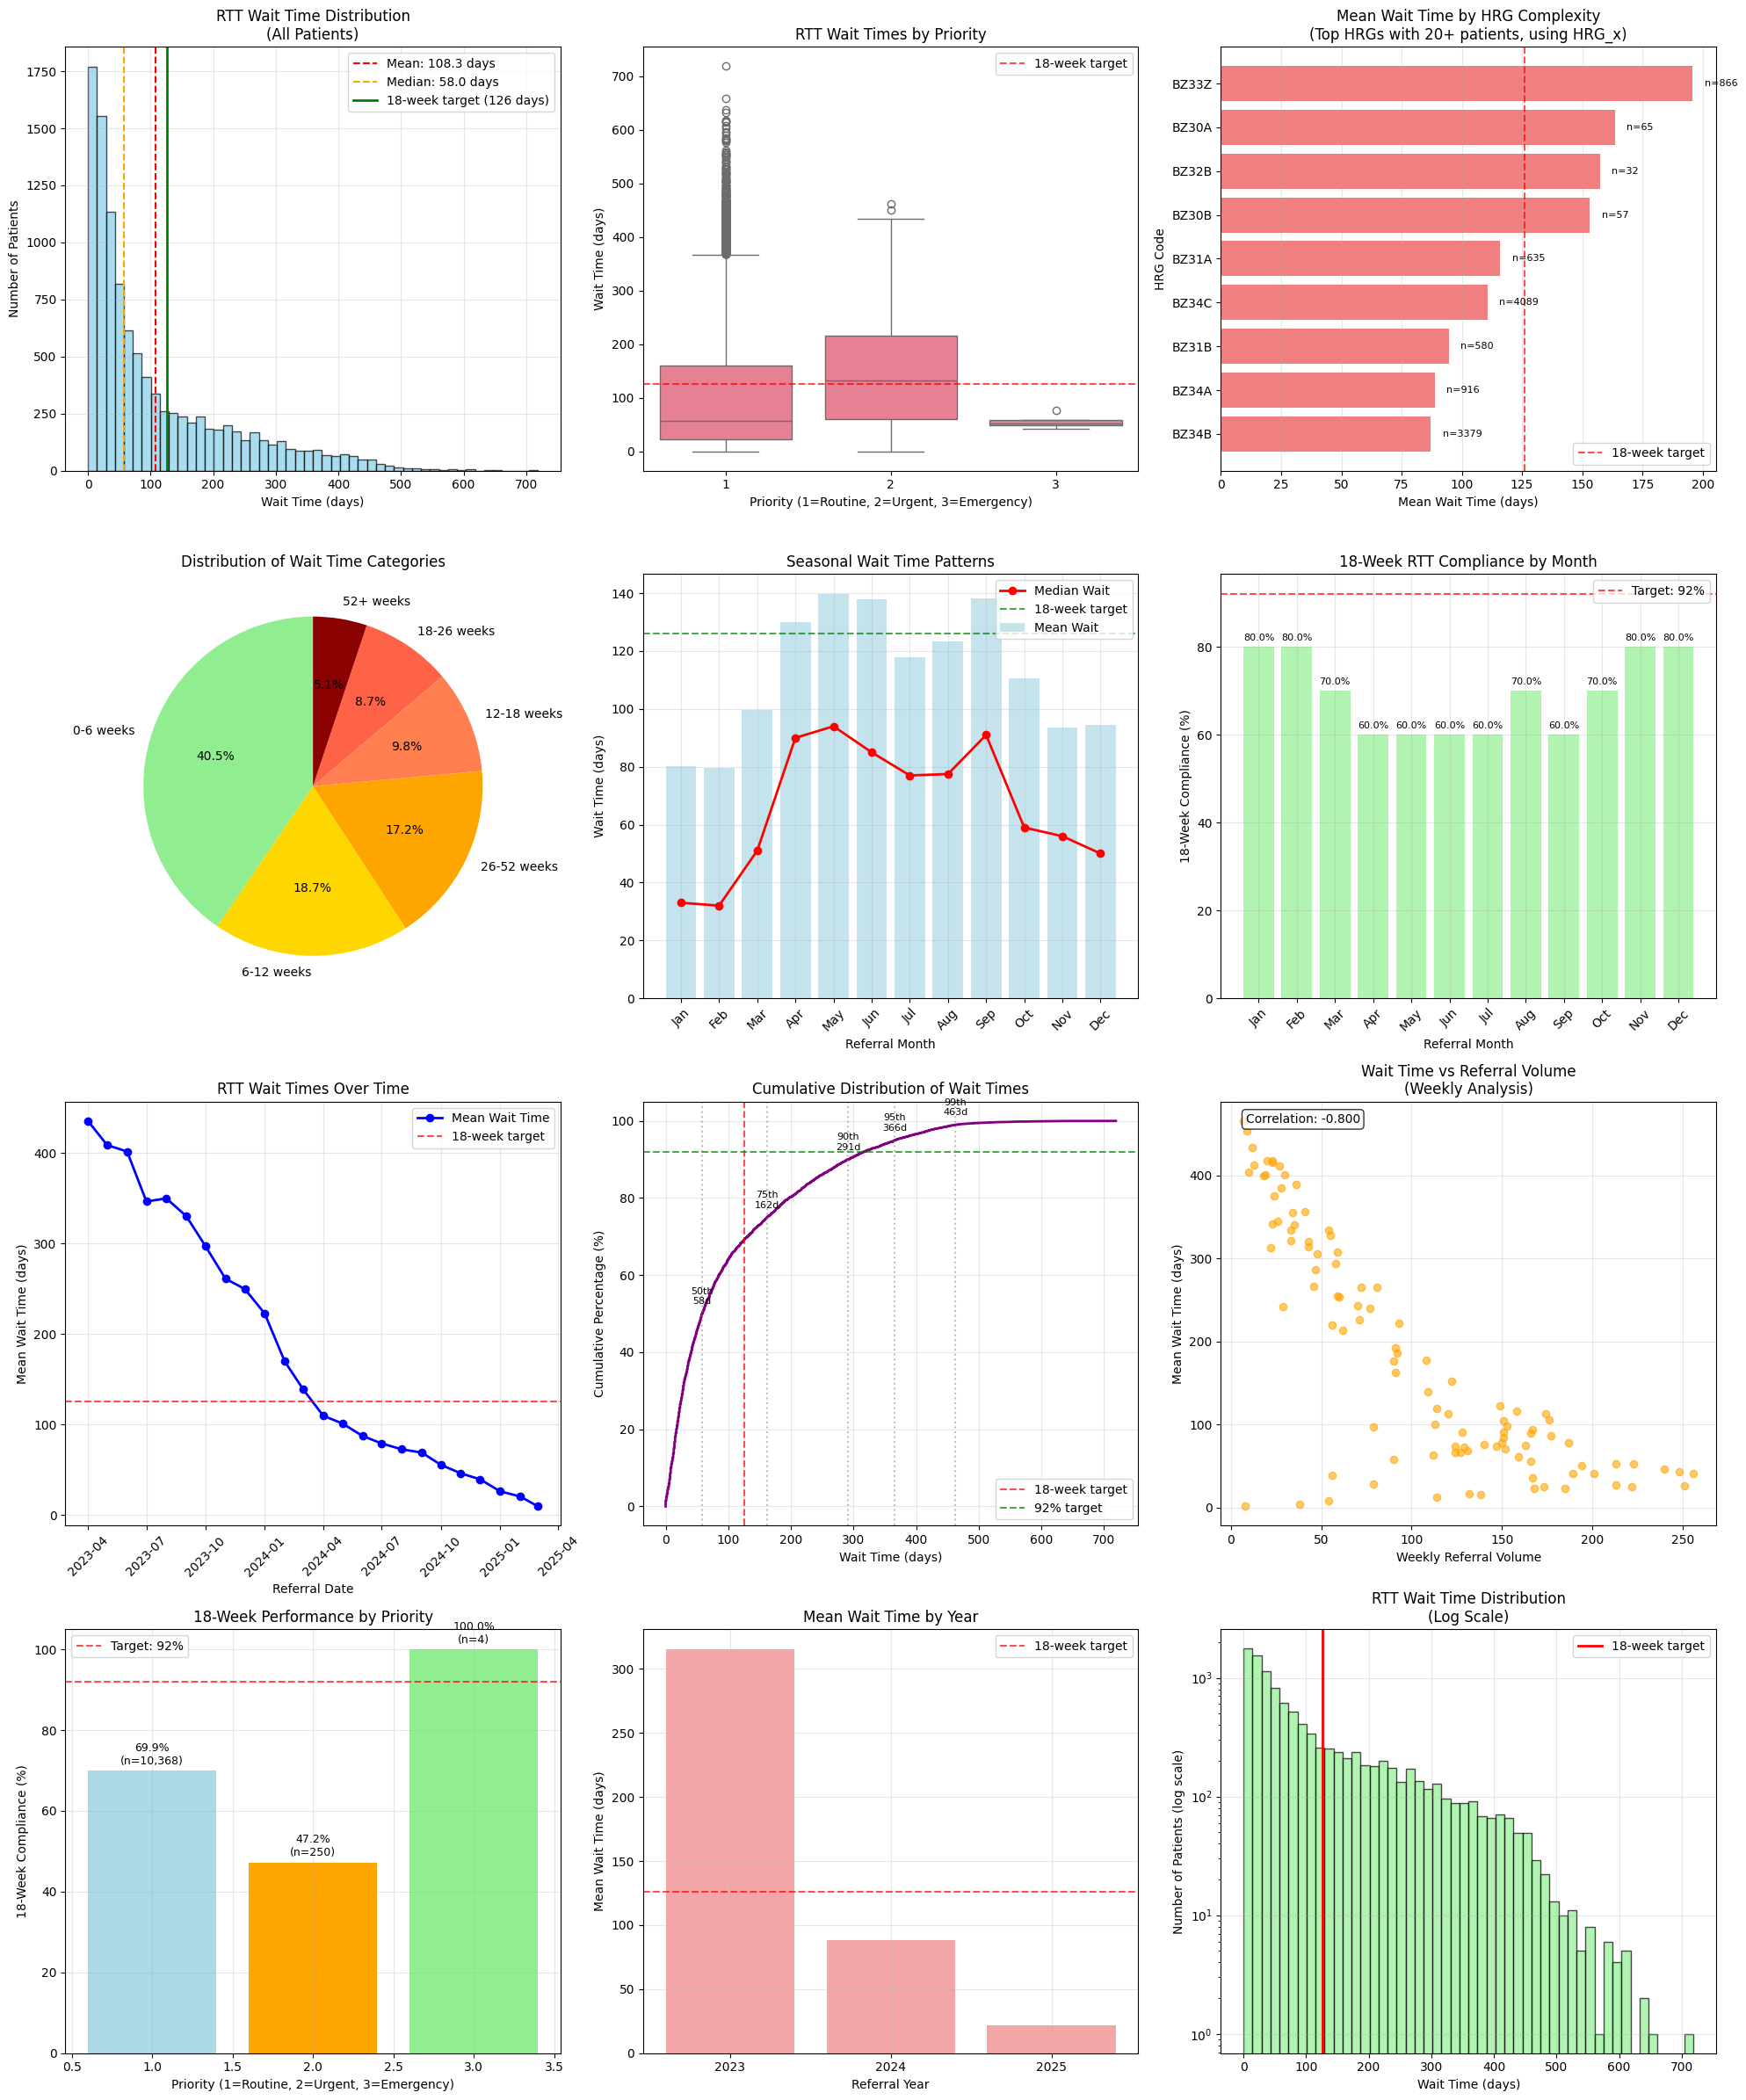


=== DETAILED STATISTICS SUMMARY ===

1. OVERALL PERFORMANCE:
   • Total valid RTT records: 10,622
   • Mean wait: 108.3 days (15.5 weeks)
   • Median wait: 58.0 days (8.3 weeks)
   • 18-week compliance: 69.4%
   • Patients over 18 weeks: 3,248 (30.6%)

2. WAIT TIME PERCENTILES:
   • 25th percentile: 22.0 days (3.1 weeks)
   • 50th percentile: 58.0 days (8.3 weeks)
   • 75th percentile: 162.0 days (23.1 weeks)
   • 90th percentile: 291.0 days (41.6 weeks)
   • 95th percentile: 366.0 days (52.3 weeks)
   • 99th percentile: 463.0 days (66.1 weeks)

3. PRIORITY ANALYSIS:
   • Priority 1 (Routine): 10,368 patients, 107.4 days mean, 69.9% compliant
   • Priority 2 (Urgent): 250 patients, 146.6 days mean, 47.2% compliant
   • Priority 3 (Emergency): 4 patients, 55.5 days mean, 100.0% compliant

4. SEASONAL INSIGHTS:
   • Best performing month: Feb (79.7 days mean)
   • Worst performing month: May (139.6 days mean)
   • Seasonal variation: 22.3 days standard deviation

5. COMPLEXITY ANALYSIS:

In [55]:

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


print(f"Analysis Period: {simulation_start} to {simulation_end}")
print(f"Total patients: {len(matched_sim):,}")

matched_sim['referral_date'] = pd.to_datetime(matched_sim['Start_clock_date'])
matched_sim['surgery_date'] = pd.to_datetime(matched_sim['Activity Date'])
matched_sim['rtt_wait_days'] = (matched_sim['surgery_date'] - matched_sim['referral_date']).dt.days

# Clean data 
rtt_data = matched_sim[matched_sim['rtt_wait_days'] >= 0].copy()
print(f"Valid RTT data: {len(rtt_data):,} patients")

# derived columns for analysis
rtt_data['referral_month'] = rtt_data['referral_date'].dt.month
rtt_data['referral_quarter'] = rtt_data['referral_date'].dt.quarter
rtt_data['referral_year'] = rtt_data['referral_date'].dt.year
rtt_data['surgery_month'] = rtt_data['surgery_date'].dt.month
rtt_data['rtt_wait_weeks'] = rtt_data['rtt_wait_days'] / 7
rtt_data['within_18_weeks'] = rtt_data['rtt_wait_days'] <= 126
rtt_data['wait_category'] = pd.cut(rtt_data['rtt_wait_days'], 
                                  bins=[0, 42, 84, 126, 182, 365, float('inf')],
                                  labels=['0-6 weeks', '6-12 weeks', '12-18 weeks', 
                                         '18-26 weeks', '26-52 weeks', '52+ weeks'])

# Basic statistics
print(f"Mean: {rtt_data['rtt_wait_days'].mean():.1f} days ({rtt_data['rtt_wait_days'].mean()/7:.1f} weeks)")
print(f"Median: {rtt_data['rtt_wait_days'].median():.1f} days ({rtt_data['rtt_wait_days'].median()/7:.1f} weeks)")
print(f"Standard Deviation: {rtt_data['rtt_wait_days'].std():.1f} days")
print(f"Min: {rtt_data['rtt_wait_days'].min():.0f} days")
print(f"Max: {rtt_data['rtt_wait_days'].max():.0f} days")
print(f"18-week compliance: {(rtt_data['within_18_weeks'].sum() / len(rtt_data) * 100):.1f}%")

# visualizations
fig = plt.figure(figsize=(20, 24))

# 1. Overall Distribution
ax1 = plt.subplot(4, 3, 1)
plt.hist(rtt_data['rtt_wait_days'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(rtt_data['rtt_wait_days'].mean(), color='red', linestyle='--', label=f'Mean: {rtt_data["rtt_wait_days"].mean():.1f} days')
plt.axvline(rtt_data['rtt_wait_days'].median(), color='orange', linestyle='--', label=f'Median: {rtt_data["rtt_wait_days"].median():.1f} days')
plt.axvline(126, color='green', linestyle='-', linewidth=2, label='18-week target (126 days)')
plt.xlabel('Wait Time (days)')
plt.ylabel('Number of Patients')
plt.title('RTT Wait Time Distribution\n(All Patients)')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Box Plot by Priority
ax2 = plt.subplot(4, 3, 2)
if 'Priority' in rtt_data.columns:
    priority_order = sorted(rtt_data['Priority'].unique())
    sns.boxplot(data=rtt_data, x='Priority', y='rtt_wait_days', order=priority_order)
    plt.axhline(126, color='red', linestyle='--', alpha=0.7, label='18-week target')
    plt.xlabel('Priority (1=Routine, 2=Urgent, 3=Emergency)')
    plt.ylabel('Wait Time (days)')
    plt.title('RTT Wait Times by Priority')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No Priority Data Available', ha='center', va='center', transform=ax2.transAxes)
    plt.title('Priority Analysis Not Available')

# 3. HRG Complexity Analysis
ax3 = plt.subplot(4, 3, 3)

# Check for multiple possible HRG column names
hrg_column = None
possible_hrg_columns = ['hrg_x', 'HRG', 'hrg', 'HRG_x', 'HRG Code', 'hrg_code', 'hrg_y']

print(f"Available columns: {rtt_data.columns.tolist()}")
for col in possible_hrg_columns:
    if col in rtt_data.columns:
        hrg_column = col
        print(f"Found HRG column: {hrg_column}")
        break

if hrg_column and rtt_data[hrg_column].notna().sum() > 0:
    # Remove any null values and analyze
    hrg_data = rtt_data[rtt_data[hrg_column].notna()]
    print(f"Non-null HRG records: {len(hrg_data)}")
    print(f"Unique HRG codes: {hrg_data[hrg_column].nunique()}")
    print(f"Sample HRG values: {hrg_data[hrg_column].unique()[:5]}")
    
    hrg_stats = hrg_data.groupby(hrg_column)['rtt_wait_days'].agg(['mean', 'count']).reset_index()
    hrg_stats = hrg_stats[hrg_stats['count'] >= 20].sort_values('mean', ascending=True)  # Only HRGs with 20+ patients
    
    if len(hrg_stats) > 0:
        # Limit to top 10 for readability
        hrg_stats = hrg_stats.tail(10) if len(hrg_stats) > 10 else hrg_stats
        
        bars = plt.barh(range(len(hrg_stats)), hrg_stats['mean'], color='lightcoral')
        plt.axvline(126, color='red', linestyle='--', alpha=0.7, label='18-week target')
        plt.xlabel('Mean Wait Time (days)')
        plt.ylabel('HRG Code')
        plt.title(f'Mean Wait Time by HRG Complexity\n(Top HRGs with 20+ patients, using {hrg_column})')
        plt.yticks(range(len(hrg_stats)), hrg_stats[hrg_column])
        plt.legend()
        plt.grid(True, alpha=0.3, axis='x')
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, hrg_stats['count'])):
            plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
                    f'n={count}', va='center', fontsize=8)
    else:
        plt.text(0.5, 0.5, f'No HRGs with 20+ patients found\nUsing column: {hrg_column}', 
                ha='center', va='center', transform=ax3.transAxes)
else:
    plt.text(0.5, 0.5, f'No HRG Data Available\nChecked columns: {possible_hrg_columns}\nAvailable: {rtt_data.columns.tolist()[:5]}...', 
            ha='center', va='center', transform=ax3.transAxes, fontsize=8)
    plt.title('HRG Analysis Not Available')

# 4. Wait Category Distribution
ax4 = plt.subplot(4, 3, 4)
wait_cat_counts = rtt_data['wait_category'].value_counts()
colors = ['lightgreen', 'gold', 'orange', 'coral', 'tomato', 'darkred']
plt.pie(wait_cat_counts.values, labels=wait_cat_counts.index, autopct='%1.1f%%', 
        colors=colors[:len(wait_cat_counts)], startangle=90)
plt.title('Distribution of Wait Time Categories')

# 5. Seasonal Patterns - Monthly
ax5 = plt.subplot(4, 3, 5)
monthly_stats = rtt_data.groupby('referral_month').agg({
    'rtt_wait_days': ['mean', 'median', 'count'],
    'within_18_weeks': 'mean'
}).round(1)
monthly_stats.columns = ['mean_wait', 'median_wait', 'count', 'compliance_rate']

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x_pos = range(len(monthly_stats))

plt.bar(x_pos, monthly_stats['mean_wait'], alpha=0.7, color='lightblue', label='Mean Wait')
plt.plot(x_pos, monthly_stats['median_wait'], marker='o', color='red', linewidth=2, label='Median Wait')
plt.axhline(126, color='green', linestyle='--', alpha=0.7, label='18-week target')
plt.xlabel('Referral Month')
plt.ylabel('Wait Time (days)')
plt.title('Seasonal Wait Time Patterns')
plt.xticks(x_pos, [month_names[i-1] for i in monthly_stats.index])
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 6. 18-Week Compliance by Month
ax6 = plt.subplot(4, 3, 6)
compliance_by_month = (monthly_stats['compliance_rate'] * 100)
plt.bar(x_pos, compliance_by_month, color='lightgreen', alpha=0.7)
plt.axhline(92, color='red', linestyle='--', alpha=0.7, label='Target: 92%')
plt.xlabel('Referral Month')
plt.ylabel('18-Week Compliance (%)')
plt.title('18-Week RTT Compliance by Month')
plt.xticks(x_pos, [month_names[i-1] for i in monthly_stats.index])
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
for i, v in enumerate(compliance_by_month):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=8)

# 7. Time Series Analysis
ax7 = plt.subplot(4, 3, 7)
# Monthly time series
monthly_timeseries = rtt_data.groupby([rtt_data['referral_date'].dt.to_period('M')]).agg({
    'rtt_wait_days': 'mean',
    'within_18_weeks': 'mean'
}).reset_index()
monthly_timeseries['referral_date'] = monthly_timeseries['referral_date'].dt.to_timestamp()

plt.plot(monthly_timeseries['referral_date'], monthly_timeseries['rtt_wait_days'], 
         marker='o', linewidth=2, color='blue', label='Mean Wait Time')
plt.axhline(126, color='red', linestyle='--', alpha=0.7, label='18-week target')
plt.xlabel('Referral Date')
plt.ylabel('Mean Wait Time (days)')
plt.title('RTT Wait Times Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 8. Cumulative Distribution Function
ax8 = plt.subplot(4, 3, 8)
sorted_waits = np.sort(rtt_data['rtt_wait_days'])
cumulative_prob = np.arange(1, len(sorted_waits) + 1) / len(sorted_waits)
plt.plot(sorted_waits, cumulative_prob * 100, linewidth=2, color='purple')
plt.axvline(126, color='red', linestyle='--', alpha=0.7, label='18-week target')
plt.axhline(92, color='green', linestyle='--', alpha=0.7, label='92% target')
plt.xlabel('Wait Time (days)')
plt.ylabel('Cumulative Percentage (%)')
plt.title('Cumulative Distribution of Wait Times')
plt.legend()
plt.grid(True, alpha=0.3)

# Find key percentiles
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    value = np.percentile(sorted_waits, p)
    plt.axvline(value, color='gray', linestyle=':', alpha=0.5)
    plt.text(value, p + 2, f'{p}th\n{value:.0f}d', ha='center', va='bottom', fontsize=8)

# 9. Wait Time vs Volume Analysis
ax9 = plt.subplot(4, 3, 9)
# Weekly volume and average wait time
rtt_data['week'] = rtt_data['referral_date'].dt.to_period('W')
weekly_analysis = rtt_data.groupby('week').agg({
    'rtt_wait_days': 'mean',
    'Local Patient Identifier': 'count'
}).reset_index()
weekly_analysis.columns = ['week', 'mean_wait', 'volume']

plt.scatter(weekly_analysis['volume'], weekly_analysis['mean_wait'], alpha=0.6, color='orange')
plt.xlabel('Weekly Referral Volume')
plt.ylabel('Mean Wait Time (days)')
plt.title('Wait Time vs Referral Volume\n(Weekly Analysis)')
plt.grid(True, alpha=0.3)

# Add correlation coefficient
correlation = weekly_analysis['volume'].corr(weekly_analysis['mean_wait'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=ax9.transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 10. Priority Performance Comparison
ax10 = plt.subplot(4, 3, 10)
if 'Priority' in rtt_data.columns:
    priority_performance = rtt_data.groupby('Priority').agg({
        'within_18_weeks': 'mean',
        'rtt_wait_days': 'count'
    }).round(3)
    priority_performance.columns = ['compliance_rate', 'count']
    priority_performance['compliance_pct'] = priority_performance['compliance_rate'] * 100
    
    bars = plt.bar(priority_performance.index, priority_performance['compliance_pct'], 
                   color=['lightblue', 'orange', 'lightgreen'])
    plt.axhline(92, color='red', linestyle='--', alpha=0.7, label='Target: 92%')
    plt.xlabel('Priority (1=Routine, 2=Urgent, 3=Emergency)')
    plt.ylabel('18-Week Compliance (%)')
    plt.title('18-Week Performance by Priority')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add count labels on bars
    for i, (bar, count) in enumerate(zip(bars, priority_performance['count'])):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1, 
                f'{height:.1f}%\n(n={count:,})', ha='center', va='bottom', fontsize=9)

# 11. Distribution by Year/Quarter
ax11 = plt.subplot(4, 3, 11)
if len(rtt_data['referral_year'].unique()) > 1:
    yearly_stats = rtt_data.groupby('referral_year').agg({
        'rtt_wait_days': 'mean',
        'within_18_weeks': 'mean'
    }).round(1)
    
    x_pos = range(len(yearly_stats))
    plt.bar(x_pos, yearly_stats['rtt_wait_days'], alpha=0.7, color='lightcoral')
    plt.axhline(126, color='red', linestyle='--', alpha=0.7, label='18-week target')
    plt.xlabel('Referral Year')
    plt.ylabel('Mean Wait Time (days)')
    plt.title('Mean Wait Time by Year')
    plt.xticks(x_pos, yearly_stats.index)
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    quarterly_stats = rtt_data.groupby('referral_quarter').agg({
        'rtt_wait_days': 'mean',
        'within_18_weeks': 'mean'
    }).round(1)
    
    x_pos = range(len(quarterly_stats))
    plt.bar(x_pos, quarterly_stats['rtt_wait_days'], alpha=0.7, color='lightcoral')
    plt.axhline(126, color='red', linestyle='--', alpha=0.7, label='18-week target')
    plt.xlabel('Quarter')
    plt.ylabel('Mean Wait Time (days)')
    plt.title('Mean Wait Time by Quarter')
    plt.xticks(x_pos, [f'Q{q}' for q in quarterly_stats.index])
    plt.legend()
    plt.grid(True, alpha=0.3)

# 12. Log-scale distribution to show right tail
ax12 = plt.subplot(4, 3, 12)
plt.hist(rtt_data['rtt_wait_days'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(126, color='red', linestyle='-', linewidth=2, label='18-week target')
plt.xlabel('Wait Time (days)')
plt.ylabel('Number of Patients (log scale)')
plt.title('RTT Wait Time Distribution\n(Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary Statistics Table
print(f"   • Total valid RTT records: {len(rtt_data):,}")
print(f"   • Mean wait: {rtt_data['rtt_wait_days'].mean():.1f} days ({rtt_data['rtt_wait_days'].mean()/7:.1f} weeks)")
print(f"   • Median wait: {rtt_data['rtt_wait_days'].median():.1f} days ({rtt_data['rtt_wait_days'].median()/7:.1f} weeks)")
print(f"   • 18-week compliance: {(rtt_data['within_18_weeks'].sum() / len(rtt_data) * 100):.1f}%")
print(f"   • Patients over 18 weeks: {(~rtt_data['within_18_weeks']).sum():,} ({(~rtt_data['within_18_weeks']).sum() / len(rtt_data) * 100:.1f}%)")

print(f"\nWAIT TIME PERCENTILES:")
for p in [25, 50, 75, 90, 95, 99]:
    value = rtt_data['rtt_wait_days'].quantile(p/100)
    print(f"   • {p}th percentile: {value:.1f} days ({value/7:.1f} weeks)")

print(f"\n3. PRIORITY ANALYSIS:")
if 'Priority' in rtt_data.columns:
    for priority in sorted(rtt_data['Priority'].unique()):
        if pd.notna(priority):
            subset = rtt_data[rtt_data['Priority'] == priority]
            compliance = (subset['within_18_weeks'].sum() / len(subset)) * 100
            priority_name = 'Routine' if priority == 1 else 'Urgent' if priority == 2 else 'Emergency'
            print(f"   • Priority {priority} ({priority_name}): {len(subset):,} patients, {subset['rtt_wait_days'].mean():.1f} days mean, {compliance:.1f}% compliant")

print(f"\n4. SEASONAL INSIGHTS:")
best_month = monthly_stats.loc[monthly_stats['mean_wait'].idxmin()]
worst_month = monthly_stats.loc[monthly_stats['mean_wait'].idxmax()]
print(f"   • Best performing month: {month_names[best_month.name-1]} ({best_month['mean_wait']:.1f} days mean)")
print(f"   • Worst performing month: {month_names[worst_month.name-1]} ({worst_month['mean_wait']:.1f} days mean)")
print(f"   • Seasonal variation: {monthly_stats['mean_wait'].std():.1f} days standard deviation")

print(f"\n5. COMPLEXITY ANALYSIS:")
hrg_column = None
possible_hrg_columns = ['hrg_x', 'HRG', 'hrg', 'HRG_x', 'HRG Code', 'hrg_code', 'hrg_y']
for col in possible_hrg_columns:
    if col in rtt_data.columns and rtt_data[col].notna().sum() > 0:
        hrg_column = col
        break

if hrg_column:
    hrg_analysis = rtt_data[rtt_data[hrg_column].notna()].groupby(hrg_column).agg({
        'rtt_wait_days': ['mean', 'count'],
        'within_18_weeks': 'mean'
    }).round(1)
    hrg_analysis.columns = ['mean_wait', 'count', 'compliance']
    hrg_analysis = hrg_analysis[hrg_analysis['count'] >= 50].sort_values('mean_wait', ascending=False)
    
    if len(hrg_analysis) > 0:
        print(f"   • Most complex (longest waits): {hrg_analysis.index[0]} - {hrg_analysis.iloc[0]['mean_wait']:.1f} days")
        print(f"   • Least complex (shortest waits): {hrg_analysis.index[-1]} - {hrg_analysis.iloc[-1]['mean_wait']:.1f} days")
        print(f"   • Range between complexities: {hrg_analysis.iloc[0]['mean_wait'] - hrg_analysis.iloc[-1]['mean_wait']:.1f} days")
    else:
        print(f"   • No HRG groups with 50+ patients found")
else:
    print(f"   • No valid HRG data found")

print(f"1. PERFORMANCE GAPS:")
print(f"   • 18-week compliance is {(rtt_data['within_18_weeks'].sum() / len(rtt_data) * 100):.1f}% (target: 92%+)")
print(f"   • Gap to target: {92 - (rtt_data['within_18_weeks'].sum() / len(rtt_data) * 100):.1f} percentage points")
print(f"   • Patients affected: {(~rtt_data['within_18_weeks']).sum():,} patients waiting over 18 weeks")

print(f"\n2. BOTTLENECKS IDENTIFIED:")
if 'Priority' in rtt_data.columns:
    urgent_compliance = (rtt_data[rtt_data['Priority'] == 2]['within_18_weeks'].sum() / len(rtt_data[rtt_data['Priority'] == 2])) * 100
    if urgent_compliance < 70:
        print(f"   • CRITICAL: Urgent patients (Priority 2) only {urgent_compliance:.1f}% compliant")
print(f"   • High variability (CV = {rtt_data['rtt_wait_days'].std() / rtt_data['rtt_wait_days'].mean():.2f})")
print(f"   • Seasonal bottlenecks in {month_names[worst_month.name-1]} ({worst_month['mean_wait']:.1f} days)")

print(f"\n3. SIMULATION PRIORITIES:")
print(f"   • Focus on reducing long waits (95th percentile: {rtt_data['rtt_wait_days'].quantile(0.95):.0f} days)")
print(f"   • Address urgent patient pathway")
print(f"   • Consider seasonal capacity adjustments")
if 'hrg_x' in rtt_data.columns:
    print(f"   • Prioritize complex cases (BZ33Z) capacity")

### Provider Distribution Analysis

=== PROVIDER ANALYSIS FOR DES MODEL ===

1. ASSESSMENT PROVIDERS
Total assessment providers: 30
Top 5 assessment providers:
  NORTH WEST ANGLIA NHS FOUNDATION TRUST: 3,048 (23.1%)
  ANGLIA COMMUNITY EYE SERVICE LTD: 3,025 (22.9%)
  SPAMEDICA PETERBOROUGH: 2,947 (22.3%)
  CAMBRIDGE UNIVERSITY HOSPITALS NHS FOUNDATION TRUST: 2,840 (21.5%)
  SPAMEDICA BEDFORD: 769 (5.8%)

2. SURGERY PROVIDERS
Total surgery providers: 34
Top 5 surgery providers:
  NORTH WEST ANGLIA NHS FOUNDATION TRUST: 3,048 (23.1%)
  ANGLIA COMMUNITY EYE SERVICE LTD: 3,022 (22.9%)
  SPAMEDICA PETERBOROUGH: 2,947 (22.3%)
  CAMBRIDGE UNIVERSITY HOSPITALS NHS FOUNDATION TRUST: 2,834 (21.5%)
  SPAMEDICA BEDFORD: 770 (5.8%)

3. PROVIDER PATHWAYS (Assessment → Surgery)
Most common assessment → surgery pathways:
  NORTH WEST ANGLIA NHS FOUNDATION TRUST → NORTH WEST ANGLIA NHS FOUNDATION TRUST: 3,048 (23.1%)
  ANGLIA COMMUNITY EYE SERVICE LTD → ANGLIA COMMUNITY EYE SERVICE LTD: 3,022 (22.9%)
  SPAMEDICA PETERBOROUGH → SPAMEDICA 

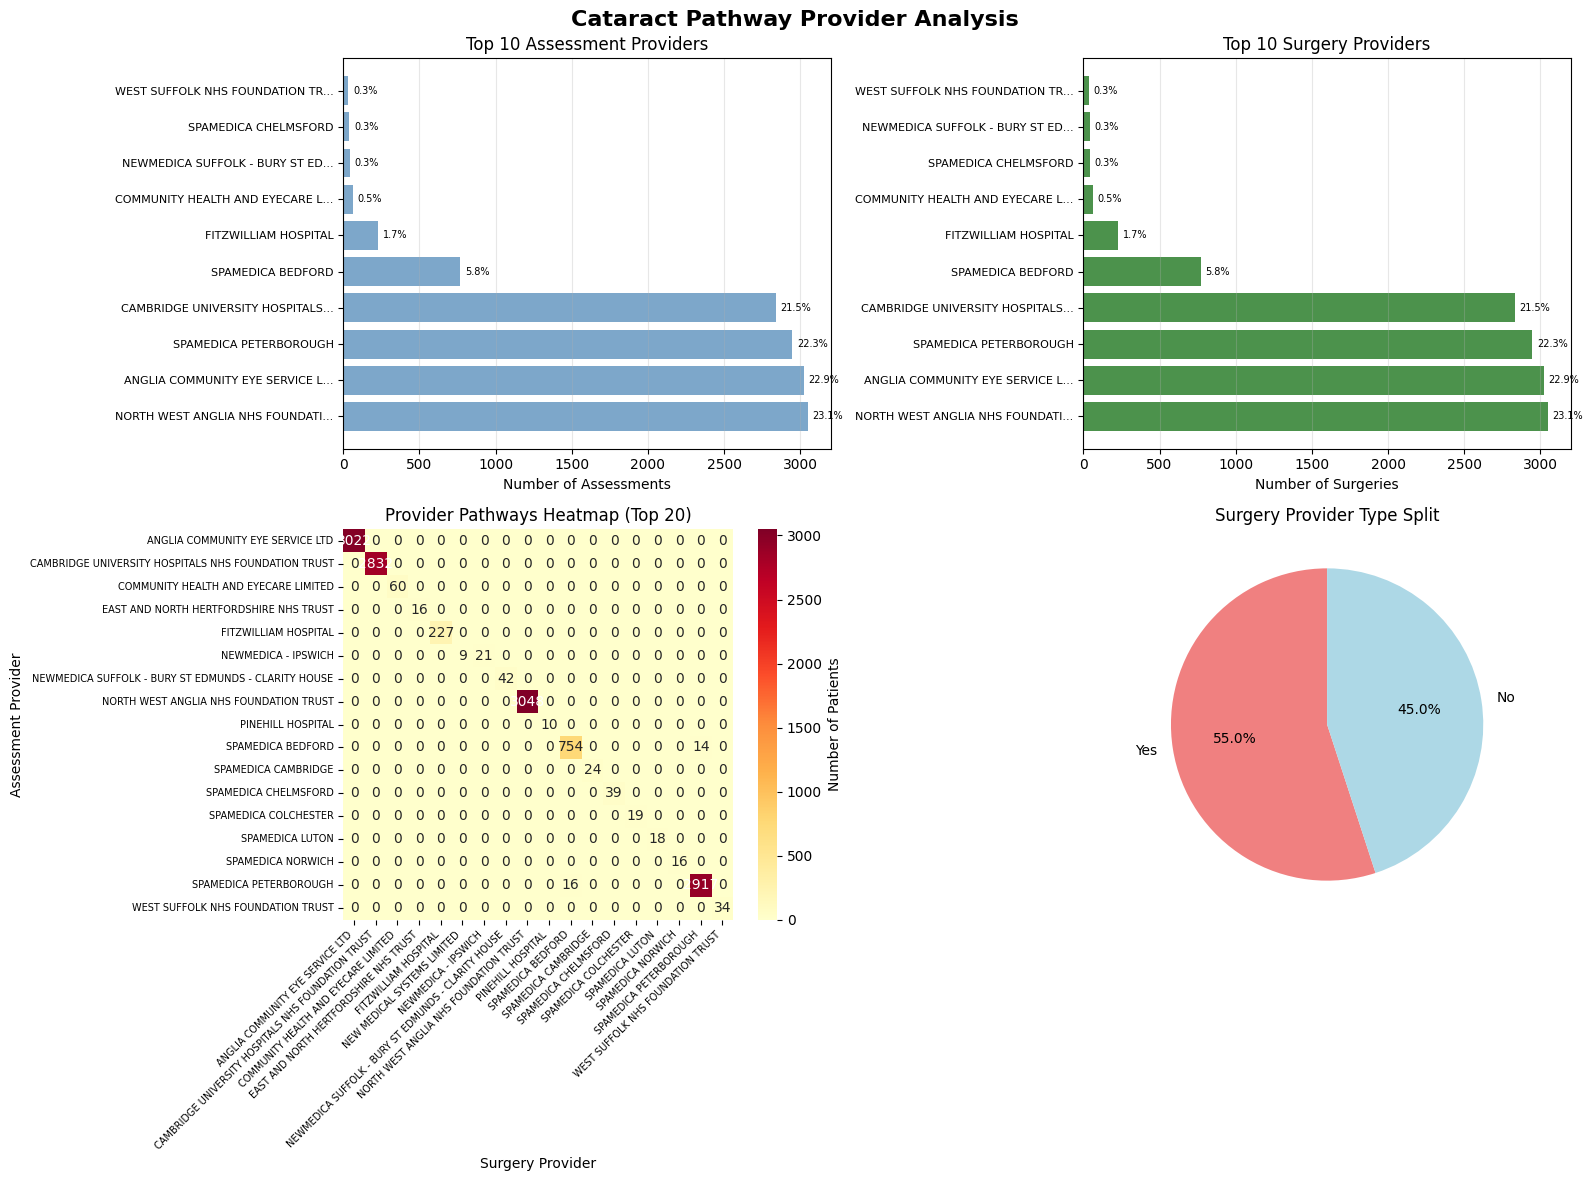


=== DES MODEL PARAMETERS ===

Assessment provider probabilities (top 5):
  'NORTH WEST ANGLIA NHS FOUNDATION TRUST': 0.2309
  'ANGLIA COMMUNITY EYE SERVICE LTD': 0.2292
  'SPAMEDICA PETERBOROUGH': 0.2233
  'CAMBRIDGE UNIVERSITY HOSPITALS NHS FOUNDATION TRUST': 0.2152
  'SPAMEDICA BEDFORD': 0.0583

Surgery provider probabilities (top 5):
  'NORTH WEST ANGLIA NHS FOUNDATION TRUST': 0.2309
  'ANGLIA COMMUNITY EYE SERVICE LTD': 0.2290
  'SPAMEDICA PETERBOROUGH': 0.2233
  'CAMBRIDGE UNIVERSITY HOSPITALS NHS FOUNDATION TRUST': 0.2147
  'SPAMEDICA BEDFORD': 0.0583

Provider pathway probabilities (top 5):
  'NORTH WEST ANGLIA NHS FOUNDATION TRUST' → 'NORTH WEST ANGLIA NHS FOUNDATION TRUST': 0.2309
  'ANGLIA COMMUNITY EYE SERVICE LTD' → 'ANGLIA COMMUNITY EYE SERVICE LTD': 0.2290
  'SPAMEDICA PETERBOROUGH' → 'SPAMEDICA PETERBOROUGH': 0.2210
  'CAMBRIDGE UNIVERSITY HOSPITALS NHS FOUNDATION TRUST' → 'CAMBRIDGE UNIVERSITY HOSPITALS NHS FOUNDATION TRUST': 0.2146
  'SPAMEDICA BEDFORD' → 'SPAMEDICA B

In [143]:
# Provider Analysis for DES Model Generator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np


# Analyze assessment providers (where patients were assessed after referral)
print("\n1. ASSESSMENT PROVIDERS")
assessment_providers = matched_sim['Provider_x'].value_counts()
print(f"Total assessment providers: {len(assessment_providers)}")
print(f"Top 5 assessment providers:")
for provider, count in assessment_providers.head().items():
    pct = (count/len(matched_sim))*100
    print(f"  {provider}: {count:,} ({pct:.1f}%)")

# Analyze surgery providers
print("\n2. SURGERY PROVIDERS")
surgery_providers = matched_sim['Provider_y'].value_counts()
print(f"Total surgery providers: {len(surgery_providers)}")
print(f"Top 5 surgery providers:")
for provider, count in surgery_providers.head().items():
    pct = (count/len(matched_sim))*100
    print(f"  {provider}: {count:,} ({pct:.1f}%)")

# Check for provider pathways (assessment → surgery)
print("\n3. PROVIDER PATHWAYS (Assessment → Surgery)")
pathway_analysis = matched_sim.groupby(['Provider_x', 'Provider_y']).size().reset_index(name='count')
pathway_analysis = pathway_analysis.sort_values('count', ascending=False)

print(f"Most common assessment → surgery pathways:")
for _, row in pathway_analysis.head(10).iterrows():
    pct = (row['count']/len(matched_sim))*100
    print(f"  {row['Provider_x']} → {row['Provider_y']}: {row['count']:,} ({pct:.1f}%)")

# Independent sector analysis
print("\n4. INDEPENDENT SECTOR ANALYSIS")
if 'Independent Sector_y' in matched_sim.columns:
    indie_split = matched_sim['Independent Sector_y'].value_counts()
    print("Surgery provider type:")
    for sector, count in indie_split.items():
        pct = (count/len(matched_sim))*100
        print(f"  {sector}: {count:,} ({pct:.1f}%)")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cataract Pathway Provider Analysis', fontsize=16, fontweight='bold')

# 1. Top assessment providers
top_assess = assessment_providers.head(10)
ax1 = axes[0, 0]
bars1 = ax1.barh(range(len(top_assess)), top_assess.values, color='steelblue', alpha=0.7)
ax1.set_yticks(range(len(top_assess)))
ax1.set_yticklabels([p[:30] + '...' if len(p) > 30 else p for p in top_assess.index], fontsize=8)
ax1.set_xlabel('Number of Assessments')
ax1.set_title('Top 10 Assessment Providers')
ax1.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (bar, val) in enumerate(zip(bars1, top_assess.values)):
    pct = (val/len(matched_sim))*100
    ax1.text(bar.get_width() + max(top_assess.values)*0.01, bar.get_y() + bar.get_height()/2, 
             f'{pct:.1f}%', va='center', fontsize=7)

# 2. Top surgery providers
top_surg = surgery_providers.head(10)
ax2 = axes[0, 1]
bars2 = ax2.barh(range(len(top_surg)), top_surg.values, color='darkgreen', alpha=0.7)
ax2.set_yticks(range(len(top_surg)))
ax2.set_yticklabels([p[:30] + '...' if len(p) > 30 else p for p in top_surg.index], fontsize=8)
ax2.set_xlabel('Number of Surgeries')
ax2.set_title('Top 10 Surgery Providers')
ax2.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (bar, val) in enumerate(zip(bars2, top_surg.values)):
    pct = (val/len(matched_sim))*100
    ax2.text(bar.get_width() + max(top_surg.values)*0.01, bar.get_y() + bar.get_height()/2, 
             f'{pct:.1f}%', va='center', fontsize=7)

# 3. Provider pathway heatmap (top pathways only)
top_pathways = pathway_analysis.head(20)
pathway_matrix = top_pathways.pivot_table(
    index='Provider_x', 
    columns='Provider_y', 
    values='count', 
    fill_value=0
).astype(int)  # Convert to integer to avoid float formatting issues

ax3 = axes[1, 0]
sns.heatmap(pathway_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Patients'}, ax=ax3)
ax3.set_title('Provider Pathways Heatmap (Top 20)')
ax3.set_xlabel('Surgery Provider')
ax3.set_ylabel('Assessment Provider')
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right', fontsize=7)
plt.setp(ax3.get_yticklabels(), rotation=0, fontsize=7)

# 4. Independent sector split (if available)
ax4 = axes[1, 1]
if 'Independent Sector_y' in matched_sim.columns:
    indie_counts = matched_sim['Independent Sector_y'].value_counts()
    colors = ['lightcoral', 'lightblue']
    wedges, texts, autotexts = ax4.pie(indie_counts.values, labels=indie_counts.index, 
                                       autopct='%1.1f%%', colors=colors, startangle=90)
    ax4.set_title('Surgery Provider Type Split')
else:
    ax4.text(0.5, 0.5, 'Independent Sector\ndata not available', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Surgery Provider Type Split')

plt.tight_layout()
plt.show()

# Generate provider probability distributions for DES model
print("\n=== DES MODEL PARAMETERS ===")

# Assessment provider probabilities
assess_probs = (assessment_providers / len(matched_sim)).to_dict()
print(f"\nAssessment provider probabilities (top 5):")
for provider, prob in list(assess_probs.items())[:5]:
    print(f"  '{provider}': {prob:.4f}")

# Surgery provider probabilities  
surg_probs = (surgery_providers / len(matched_sim)).to_dict()
print(f"\nSurgery provider probabilities (top 5):")
for provider, prob in list(surg_probs.items())[:5]:
    print(f"  '{provider}': {prob:.4f}")

# Pathway probabilities (conditional)
print(f"\nProvider pathway probabilities (top 5):")
pathway_probs = {}
for _, row in pathway_analysis.head().iterrows():
    assess_provider = row['Provider_x']
    surg_provider = row['Provider_y']
    prob = row['count'] / len(matched_sim)
    pathway_probs[f"{assess_provider} → {surg_provider}"] = prob
    print(f"  '{assess_provider}' → '{surg_provider}': {prob:.4f}")

# Independent sector probability
if 'Independent Sector_y' in matched_sim.columns:
    indie_prob = (matched_sim['Independent Sector_y'] == 'Yes').mean()
    print(f"\nIndependent sector probability: {indie_prob:.4f}")

print(f"• {len(assessment_providers)} unique assessment providers")
print(f"• {len(surgery_providers)} unique surgery providers") 
print(f"• {len(pathway_analysis)} unique pathways")
print(f"• Top assessment provider: {assessment_providers.index[0]} ({assessment_providers.iloc[0]/len(matched_sim)*100:.1f}%)")
print(f"• Top surgery provider: {surgery_providers.index[0]} ({surgery_providers.iloc[0]/len(matched_sim)*100:.1f}%)")

provider_params = {
    'assessment_providers': assess_probs,
    'surgery_providers': surg_probs,
    'pathway_probabilities': pathway_probs,
    'independent_sector_prob': indie_prob if 'Independent Sector_y' in matched_sim.columns else None,
    'total_providers_assess': len(assessment_providers),
    'total_providers_surg': len(surgery_providers),
    'total_pathways': len(pathway_analysis)
}